Note, needs fix on sims_maf branch bugfix/SIM-1440-slicer-eq-fail

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.plots import PlotHandler
from lsst.sims.maf.stackers import BaseStacker

In [2]:
class RotPairStacker(BaseStacker):
    """
    Add a new column that rotates the second (third, 4rth, etc) visit in a night by
    the given rotAmount (radians).
    """
    def __init__(self, rotAmount=np.pi , fieldIDCol='fieldID', nightCol='night', rotCol='rotSkyPos'):

        self.units = ['radians']
        self.colsAdded = ['rotatedRotSkyPos']
        self.nightCol = nightCol
        self.rotCol = rotCol
        self.fieldIDCol = fieldIDCol
        self.rotAmount=np.pi

        self.colsReq = [nightCol, rotCol, fieldIDCol]

    def run(self, simData):
        simData=self._addStackers(simData)

        # Fill in the old rotation angles as default
        simData['rotatedRotSkyPos'] = simData['rotatedRotSkyPos']*0+simData[self.rotCol]

        simData.sort(order=[self.nightCol,self.fieldIDCol])

        unights = np.unique(simData[self.nightCol])
        left = np.searchsorted(simData[self.nightCol], unights, side='left')
        right = np.searchsorted(simData[self.nightCol], unights, side='right')

        for l,r in zip(left,right):
            if r-l > 1:
                ufid = np.unique(simData[self.fieldIDCol][l:r])
                fLeft = np.searchsorted(simData[self.fieldIDCol][l:r], ufid, side='left')
                fRight = np.searchsorted(simData[self.fieldIDCol][l:r],ufid, side='right')
                for fL,fR in zip(fLeft,fRight):
                    if fR-fL > 1:
                        angleStart = simData[self.rotCol][l:r][fL:fR][0]
                        newAngles = self.rotAmount*np.arange(fR-fL)+angleStart
                        newAngles = newAngles % (2.*np.pi)
                        simData['rotatedRotSkyPos'][l:r][fL:fR] = newAngles
        return simData

In [3]:
database = 'enigma_1189_sqlite.db'
opsdb = db.OpsimDatabase(database)
outDir = 'Camera'
resultsDb = db.ResultsDb(outDir=outDir)

In [4]:
rafts = [         'R:0,1', 'R:0,2', 'R:0,3',
         'R:1,0', 'R:1,1', 'R:1,2', 'R:1,3', 'R:1,4',
         'R:2,0', 'R:2,1', 'R:2,2', 'R:2,3', 'R:2,4',
         'R:3,0', 'R:3,1', 'R:3,2', 'R:3,3', 'R:3,4',
                  'R:4,1', 'R:4,2', 'R:4,3'
        ]

rafts2 = [         'R:0,1', 'R:0,2', 'R:0,3',
         'R:1,0', 'R:1,1', 'R:1,2', 'R:1,3', 'R:1,4',
         'R:2,0', 'R:2,1'
        ]

rafts1 = [                 'R:2,2', 'R:2,3', 'R:2,4',
         'R:3,0', 'R:3,1', 'R:3,2', 'R:3,3', 'R:3,4',
                  'R:4,1', 'R:4,2', 'R:4,3'
        ]

sensors = ['S:0,0', 'S:0,1', 'S:0,2',
           'S:1,0', 'S:1,1', 'S:1,2',
           'S:2,0', 'S:2,1', 'S:2,2',]

chips1 = []
for raft in rafts1:
    for sensor in sensors:
        chips1.append(raft+' '+sensor)

chips2 = []
for raft in rafts2:
    for sensor in sensors:
        chips2.append(raft+' '+sensor)

In [13]:
nside = 16
years = [1,2]#[1,2,5,10] #[0.1]
bundleList = []

In [14]:
for year in years:
    sql='night < %i and filter="r"' % (356.25*year)

    metric = metrics.CountMetric(col='expMJD', metricName='Vendor1')
    slicer = slicers.HealpixSlicer(nside=nside, useCamera=True, chipNames=chips1,
                                   lonCol='ditheredRA', latCol='ditheredDec')
    bundle = metricBundles.MetricBundle(metric,slicer,sql)
    bundleList.append(bundle)

    metric = metrics.CountMetric(col='expMJD', metricName='Vendor2')
    slicer = slicers.HealpixSlicer(nside=nside, useCamera=True, chipNames=chips2,
                                   lonCol='ditheredRA', latCol='ditheredDec')
    bundle = metricBundles.MetricBundle(metric,slicer,sql)
    bundleList.append(bundle)

    # Now let's try it with the new stacker
    metric = metrics.CountMetric(col='expMJD', metricName='Vendor1, rotAdded')
    slicer = slicers.HealpixSlicer(nside=nside, rotSkyPosColName='rotatedRotSkyPos',
                                   useCamera=True, chipNames=chips1,
                                   lonCol='ditheredRA', latCol='ditheredDec')
    bundle = metricBundles.MetricBundle(metric,slicer,sql)
    bundleList.append(bundle)

    metric = metrics.CountMetric(col='expMJD', metricName='Vendor2, rotAdded')
    slicer = slicers.HealpixSlicer(nside=nside, rotSkyPosColName='rotatedRotSkyPos',
                                   useCamera=True, chipNames=chips2)
    bundle = metricBundles.MetricBundle(metric,slicer,sql)
    bundleList.append(bundle)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


Querying database with constraint night < 712 and filter="r"
Found 95000 visits
Running:  ['opsim_Vendor1_night_lt_712_and_r_HEAL']
Completed metric generation.
Running:  ['opsim_Vendor2_rotAdded_night_lt_712_and_r_HEAL']
Completed metric generation.
Running:  ['opsim_Vendor1_rotAdded_night_lt_712_and_r_HEAL']
Completed metric generation.
Running:  ['opsim_Vendor2_night_lt_712_and_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database with constraint night < 356 and filter="r"
Found 36353 visits
Running:  ['opsim_Vendor2_night_lt_356_and_r_HEAL']
Completed metric generation.
Running:  ['opsim_Vendor1_rotAdded_night_lt_356_and_r_HEAL']
Completed metric generation.
Running:  ['opsim_Vendor1_night_lt_356_and_r_HEAL']
Completed metric generation.

Warning - column rotatedRotSkyPos already present in simData, will be overwritten.
Warning - column rotatedRotSkyPos already present in simData, will be overwritten.



Running:  ['opsim_Vendor2_rotAdded_night_lt_356_and_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with night < 712 and filter="r" sqlconstraint now.
monopole: 16.9763  dipole: lon: 73.7538, lat: 73.2619, amp: 2.48426

Optimal bin calculation tried to make 228 bins, returning 200
Optimal bin calculation tried to make 273 bins, returning 200



monopole: 16.4411  dipole: lon: 158.089, lat: 82.3636, amp: 4.29031
monopole: 16.8446  dipole: lon: 67.5463, lat: 73.3186, amp: 2.54432
monopole: 15.567  dipole: lon: 45.0522, lat: 81.7397, amp: 3.3809
Plotting complete.
Plotting figures with night < 356 and filter="r" sqlconstraint now.
monopole: 4.8244  dipole: lon: -39.573, lat: -66.8324, amp: 4.75482
monopole: 4.71147  dipole: lon: -26.9241, lat: -65.2634, amp: 5.62183
monopole: 5.16827  dipole: lon: -30.759, lat: -66.989, amp: 5.26336
monopole: 4.32744  dipole: lon: -30.3692, lat: -68.9355, amp: 4.94181
Plotting complete.


/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


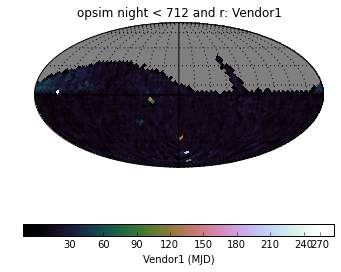

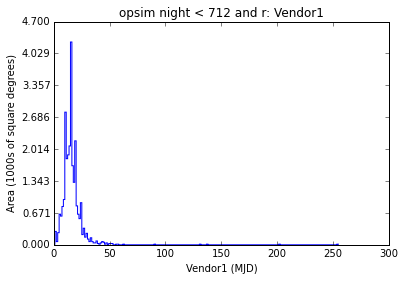

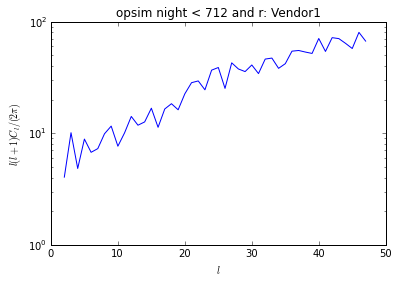

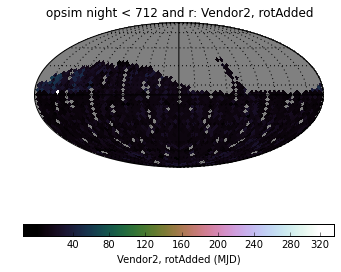

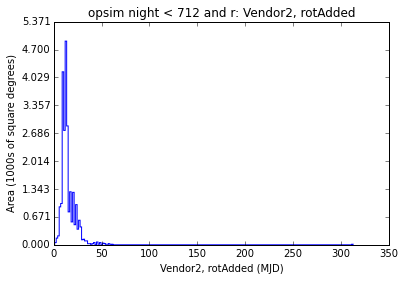

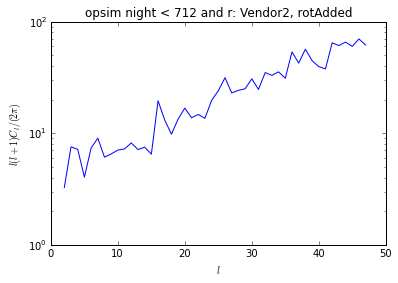

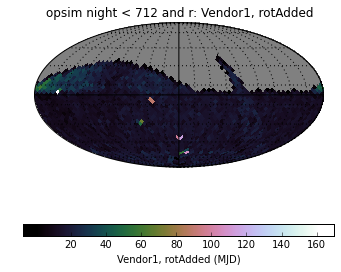

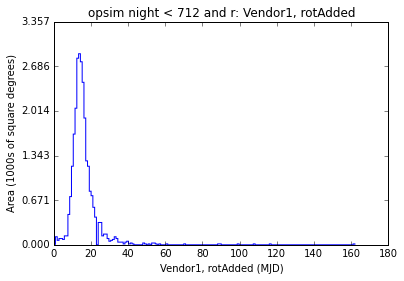

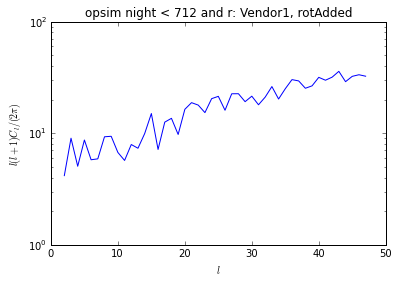

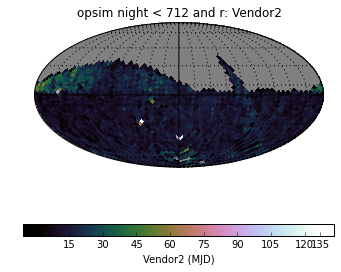

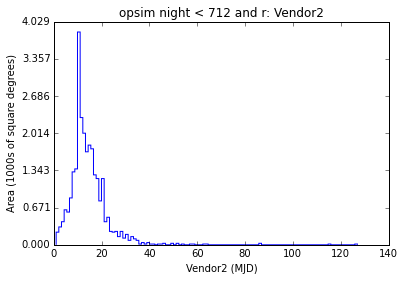

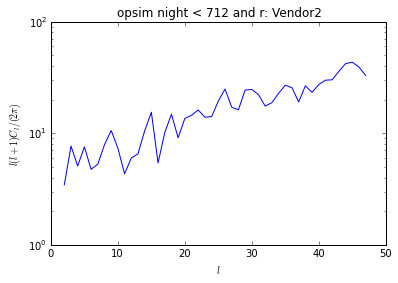

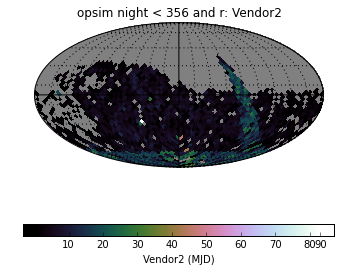

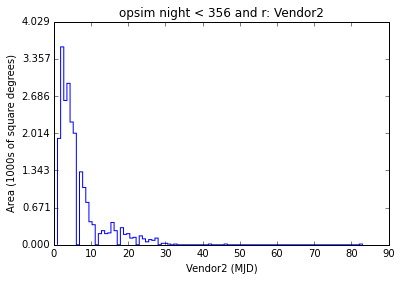

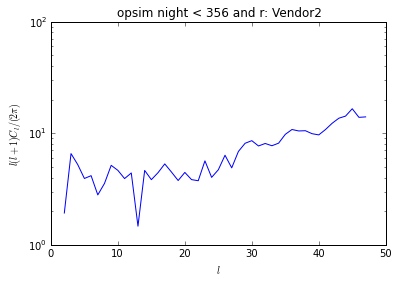

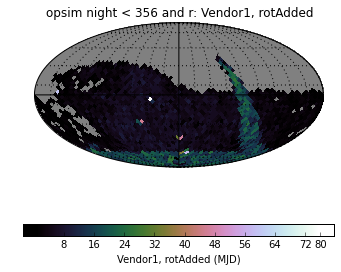

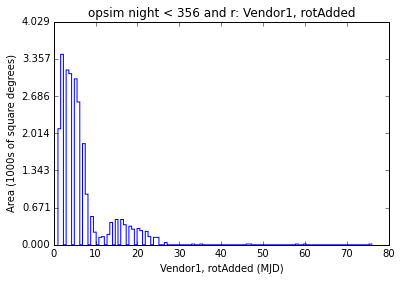

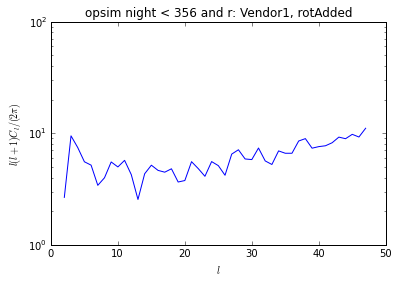

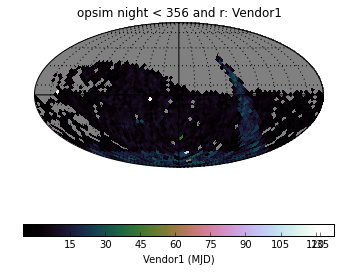

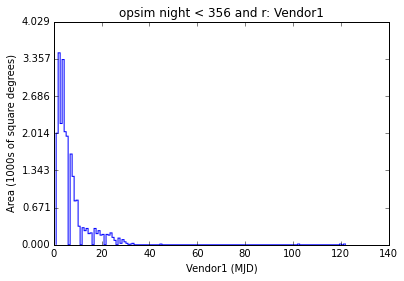

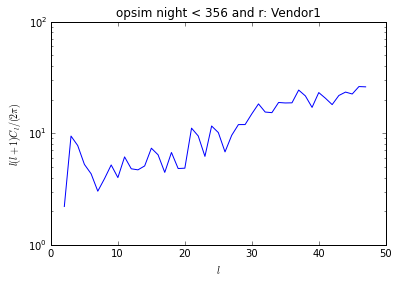

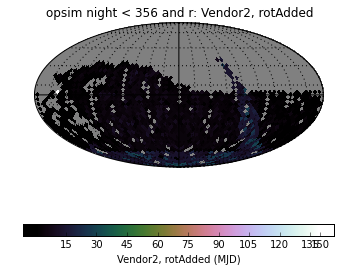

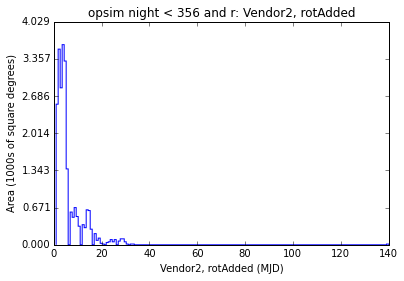

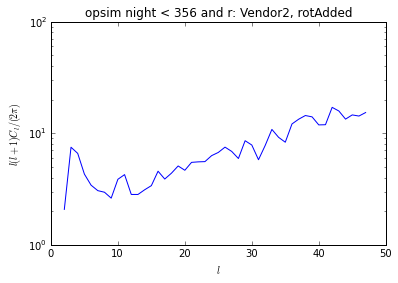

In [15]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, opsdb,
                                     outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)

OK, let's try running things with my new vector metric!